In [1]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [3]:
class SineTask():
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2*np.pi)
        self.train_x = None
    def y(self, x):
        return self.a * np.sin(x + self.b)
    def generate_data(self, K=10):
        self.train_x = np.random.uniform(-5, 5, K)
        return torch.FloatTensor(self.train_x).view(-1,1), torch.FloatTensor(self.y(self.train_x)).view(-1,1)
    def generate_trick(self, K=10):
        self.train_x = np.random.uniform(0, 5, K)
        return torch.FloatTensor(self.train_x).view(-1,1), torch.FloatTensor(self.y(self.train_x)).view(-1,1)
    def full_set(self):
        points_x = np.arange(-5, 5, .2) #50 points
        return torch.FloatTensor(points_x).view(-1,1), torch.FloatTensor(self.y(points_x)).view(-1,1)

First fit a simple neural network to the points to form a sinusoid curve

In [4]:
class SineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )
    def forward(self, x):
        return self.layers(x)

In [5]:
sample_task = SineTask()
test_x, test_y = sample_task.full_set()
model = SineModel()
loss_fn = nn.MSELoss()

def train(model):
    optimizer = optim.Adam(model.parameters())
    x, y = sample_task.generate_data(10000)
    for i in range(x.shape[0]):
        loss = loss_fn(model(x[i]), y[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
train(model)

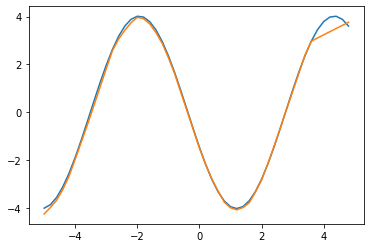

In [6]:
plt.plot(test_x, test_y)
with torch.no_grad():
    plt.plot(test_x, model(test_x))

We learned one sine function with one particular set of parameters using supervised learning as usual. What if we wanted to approximate the sine function the generated the data given a lot less points? This is where meta-learning comes in. Instead of having all these observations for one task, we leverage a lot less observations for each task over many tasks.

In [7]:
class SineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )
    def forward(self, x, params=None):
        if params == None:
            return self.layers(x)
        else:
            x = nn.functional.linear(x, params[0], params[1])
            x = nn.functional.relu(x)
            x = nn.functional.linear(x, params[2], params[3])
            x = nn.functional.relu(x)
            x = nn.functional.linear(x, params[4], params[5])
            return x

In [8]:
ALPHA = .01
BETA = .001
NUM_ITERS = 10000
BATCH_SIZE = 10
K = 5

#train on BATCH_SIZE samples from tasks, where each sample contains one training example. Each example is a dataset of K points

def train(model, optimizer, tasks):
    #technically epoch isn't the right term here
    epoch_loss = 0
    for t in range(NUM_ITERS):
        batch = np.random.choice(tasks, BATCH_SIZE)
        outer_loss = 0
    
        #iterate over each task in the batch
        for i in range(len(batch)):
            train_x, train_y = batch[i].generate_data(K) #5
            inner_loss = loss_fn(model(train_x), train_y)
            
            grad = torch.autograd.grad(inner_loss, model.parameters(), create_graph=True)
            #computes updated parameters w/o changing theta
            fast_weights = [w - ALPHA*g for (w,g) in zip(model.parameters(), grad)] #theta_prime
             
            test_x, test_y = batch[i].generate_data(K) #8
            outer_loss += loss_fn(model(test_x, params=fast_weights), test_y)
        
        epoch_loss += outer_loss
        if t % 500 == 0:
            print(epoch_loss / 500)
            epoch_loss = 0
            
        model.zero_grad()
        outer_loss.backward()
        optimizer.step()

In [9]:
tasks = [SineTask() for i in range(1000)]
maml = SineModel()
meta_optimizer = torch.optim.Adam(maml.parameters(), lr=BETA)
train(maml, meta_optimizer, tasks)

tensor(0.0378, grad_fn=<DivBackward0>)
tensor(37.9865, grad_fn=<DivBackward0>)
tensor(36.5418, grad_fn=<DivBackward0>)
tensor(34.0351, grad_fn=<DivBackward0>)
tensor(25.2738, grad_fn=<DivBackward0>)
tensor(21.9293, grad_fn=<DivBackward0>)
tensor(20.2094, grad_fn=<DivBackward0>)
tensor(19.3733, grad_fn=<DivBackward0>)
tensor(18.5141, grad_fn=<DivBackward0>)
tensor(18.0156, grad_fn=<DivBackward0>)
tensor(17.3588, grad_fn=<DivBackward0>)
tensor(17.1427, grad_fn=<DivBackward0>)
tensor(16.5995, grad_fn=<DivBackward0>)
tensor(16.0931, grad_fn=<DivBackward0>)
tensor(15.8829, grad_fn=<DivBackward0>)
tensor(15.3204, grad_fn=<DivBackward0>)
tensor(15.1199, grad_fn=<DivBackward0>)
tensor(15.2264, grad_fn=<DivBackward0>)
tensor(14.4434, grad_fn=<DivBackward0>)
tensor(14.6178, grad_fn=<DivBackward0>)


In [14]:
sample_task = SineTask()
test_x, test_y = sample_task.full_set()

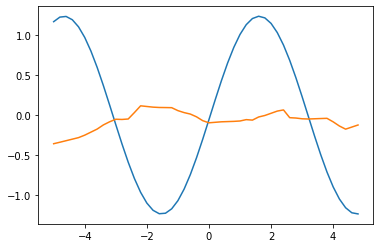

In [15]:
#no fine-tuning
plt.plot(test_x, test_y)
with torch.no_grad():
    plt.plot(test_x, maml(test_x))

In [16]:
#fine-tuning
def test(model):
    model_copy = SineModel()
    model_copy.load_state_dict(model.state_dict())
    #using Adam doesn't work well, also lr can't be too small
    optimizer = torch.optim.SGD(model_copy.parameters(), .01)
    
    for t in range(1):
        train_x, train_y = sample_task.generate_trick(K)
        loss = loss_fn(model_copy(train_x), train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    plt.scatter(train_x, train_y)
    plt.plot(test_x, test_y)
    with torch.no_grad():
        plt.plot(test_x, model_copy(test_x))

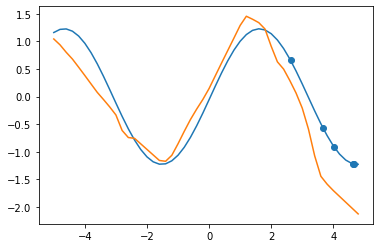

In [17]:
test(maml)